# SE3508 Introduction to Artificial Intelligence - Flower Classification Assignment

This notebook aims to develop a model that classifies 5 types of flowers using three different deep learning approaches.

### Project Structure and Model Development Process

**1. Setup and Library Imports**  
   - General libraries will be imported for data manipulation, model building, and evaluation.

**2. Data Loading and Exploration**  
   - The general structure of the dataset will be observed.  
   - Class distribution will be 

**3. Model Definitions**

   **3.1 Custom CNN**  
   - A custom CNN model will be defined and explained.

   **3.2 VGG16 - Feature Extractor**  
   - VGG16 model will be used as a feature extractor, with detailed explanations.

   **3.3 VGG16 - Fine-Tuning**  
   - The VGG16 model will be fine-tuned to perform better on the given dataset.
 given dataset.

**4. Model Training**

   **4.1 Custom CNN Model Training**  
   - Training process for the custom CNN model.

   **4.2 VGG16 - Feature Extractor Model Training**  
   - Training process for the VGG16 feature extractor model.

   **4.3 VGG16 - Fine-Tuning Model Training**  
   - Training process for the fine-tuned VGG16 model.

**5. Model Evaluation**  
   - Evaluating the performance of all models using various metrics such as accuracy, F1-Score, and confusion matrices.

**6. Feature Visualization**

   **6.1 Custom CNN Model Feature Visualization**  
   - Visualization of the learned features by the custom CNN model.

   **6.2 VGG16 Fine-Tuned Model Feature Visualization**  
   - Visualization of the learned features by the fine-tuned VGG16 model.

**7. Model Predictions Visualization**  
   - Visualizing the predictions made by the models on test data.

**8. Confusion Matrices**  
   - Displaying the confusion matrices for each model to evaluate classification performance.

**9. Performance Comparison**  
   - Comparing the performance of all models using accuracy, F1-score, and other relevant metrics.

**10. Save Results to CSV**  
   - Saving the finalnd waknesses of each model, and concluding the findings.


## 1. Setup and Importing Libraries

In [1]:
# Importing the required libraries — you can install the necessary dependencies using the requirements.txt file.
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from PIL import Image
from torchvision.utils import make_grid
import csv

import warnings
warnings.filterwarnings("ignore")

# Main directory of the src module
import sys
sys.path.append('..')

In [2]:
# Import modules from the project
from src.data import data_transforms, load_data, visualize_data_samples, get_class_distribution, plot_class_distribution
from src.models import CustomCNN, create_vgg16_feature_extractor, create_vgg16_fine_tuned, get_vgg_features
from src.train import train_model, evaluate_model, plot_training_curves
from src.visualization import visualize_features, visualize_predictions, plot_confusion_matrix, plot_comparison_chart

In [3]:
print(torch.version.cuda) 
print(torch.cuda.is_available())
print(torch.cuda.device_count())

11.8
True
1


In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device in use: {device}")

Device in use: cuda


In [5]:
# Set random seeds (for reproducibility)
torch.manual_seed(42)
np.random.seed(42)

## 2. Data Loading and Exploration

In [6]:
# Load the dataset
data_dir = '../dataset'  # Path to your dataset. Modify if needed.
train_loader, val_loader, class_names = load_data(data_dir, batch_size=32)

Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Training set size: 2746
No labeled test folder found. Using 20% of the training set for testing.


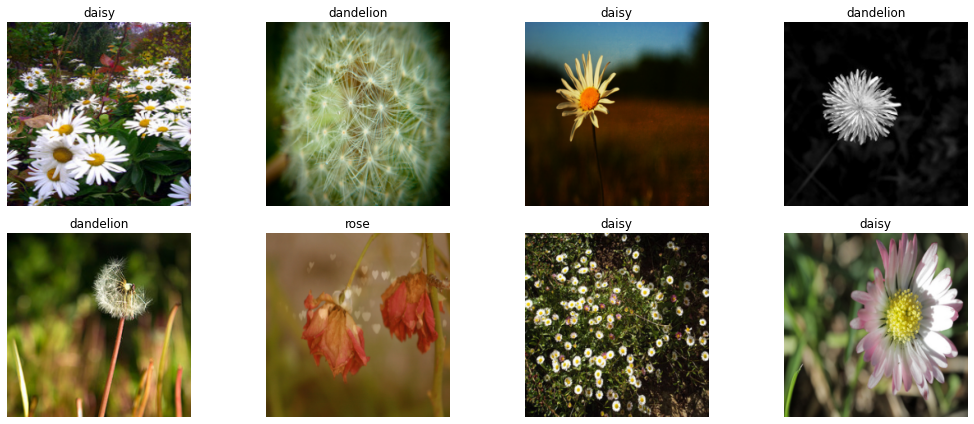

In [77]:
# Visualize samples from the dataset
_ = visualize_data_samples(train_loader, class_names)

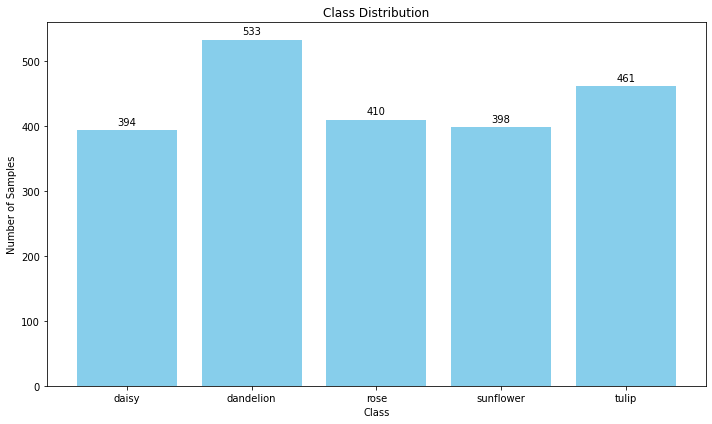

<Figure size 432x288 with 0 Axes>

In [78]:
# Analyze class distribution
class_counts = get_class_distribution(train_loader.dataset, class_names)
_ = plot_class_distribution(class_counts)

## 3. Model Definitions

### 3.1 Custom CNN Model

In [7]:
# Define the custom CNN model
custom_model = CustomCNN(num_classes=len(class_names)).to(device)
print(custom_model)

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): R

### 3.2 VGG16 - Feature Extractor

In [8]:
# Define the VGG16 feature extractor model
vgg_feature_extractor = create_vgg16_feature_extractor(num_classes=len(class_names)).to(device)
print("VGG16 Feature Extractor Model loaded.")

VGG16 Feature Extractor Model loaded.


In [9]:
# Show only trainable parameters
print("\nTrainable parameters:")
for name, param in vgg_feature_extractor.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")


Trainable parameters:
classifier.6.weight: torch.Size([5, 4096])
classifier.6.bias: torch.Size([5])


### 3.3 VGG16 - Fine-Tuning

In [10]:
# Define the VGG16 fine-tuned model
vgg_fine_tuned = create_vgg16_fine_tuned(num_classes=len(class_names)).to(device)
print("VGG16 Fine-Tuned Model loaded.")

VGG16 Fine-Tuned Model loaded.


In [11]:
# Count trainable and frozen parameters
trainable_params = 0
frozen_params = 0

for name, param in vgg_fine_tuned.named_parameters():
    if param.requires_grad:
        trainable_params += param.numel()
    else:
        frozen_params += param.numel()
        
print(f"\nNumber of trainable parameters: {trainable_params:,}")
print(f"Number of frozen parameters: {frozen_params:,}")
print(f"Total number of parameters: {trainable_params + frozen_params:,}")
print(f"Percentage of trainable parameters: {trainable_params / (trainable_params + frozen_params) * 100:.2f}%")


Number of trainable parameters: 133,725,701
Number of frozen parameters: 555,328
Total number of parameters: 134,281,029
Percentage of trainable parameters: 99.59%


## 4. Model Training

### 4.1 Custom CNN Model Training

In [12]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=0.001)

In [13]:
# Train the custom CNN model
print("Training Custom CNN Model...")
custom_model, train_losses_custom, val_losses_custom, train_accs_custom, val_accs_custom, train_time_custom = train_model(
    custom_model, train_loader, val_loader, criterion, optimizer, device, num_epochs=25, model_name="CustomCNN")

Training Custom CNN Model...
Epoch 1/25
----------


Epoch 1/25 [Train]: 100%|███████████████████████████████████████████████████| 69/69 [00:16<00:00,  4.10it/s, loss=1.37]


Training Loss: 2.5724 Accuracy: 0.3921


Epoch 1/25 [Val]: 100%|█████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.42it/s, loss=1.22]


Validation Loss: 1.2588 Accuracy: 0.4018

Epoch 2/25
----------


Epoch 2/25 [Train]: 100%|███████████████████████████████████████████████████| 69/69 [00:16<00:00,  4.18it/s, loss=1.09]


Training Loss: 1.1417 Accuracy: 0.5305


Epoch 2/25 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.41it/s, loss=0.762]


Validation Loss: 1.0705 Accuracy: 0.5418

Epoch 3/25
----------


Epoch 3/25 [Train]: 100%|███████████████████████████████████████████████████| 69/69 [00:16<00:00,  4.14it/s, loss=1.39]


Training Loss: 1.0859 Accuracy: 0.5537


Epoch 3/25 [Val]: 100%|████████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.38it/s, loss=1]


Validation Loss: 1.0046 Accuracy: 0.5745

Epoch 4/25
----------


Epoch 4/25 [Train]: 100%|██████████████████████████████████████████████████| 69/69 [00:16<00:00,  4.11it/s, loss=0.671]


Training Loss: 1.0078 Accuracy: 0.5897


Epoch 4/25 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.38it/s, loss=0.738]


Validation Loss: 1.2236 Accuracy: 0.5182

Epoch 5/25
----------


Epoch 5/25 [Train]: 100%|███████████████████████████████████████████████████| 69/69 [00:16<00:00,  4.13it/s, loss=1.08]


Training Loss: 0.9705 Accuracy: 0.6066


Epoch 5/25 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.35it/s, loss=0.624]


Validation Loss: 0.9295 Accuracy: 0.6291

Epoch 6/25
----------


Epoch 6/25 [Train]: 100%|██████████████████████████████████████████████████| 69/69 [00:16<00:00,  4.07it/s, loss=0.677]


Training Loss: 0.9271 Accuracy: 0.6280


Epoch 6/25 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.35it/s, loss=0.695]


Validation Loss: 0.9249 Accuracy: 0.6000

Epoch 7/25
----------


Epoch 7/25 [Train]: 100%|███████████████████████████████████████████████████| 69/69 [00:17<00:00,  4.06it/s, loss=1.18]


Training Loss: 0.9248 Accuracy: 0.6302


Epoch 7/25 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.35it/s, loss=0.705]


Validation Loss: 0.9513 Accuracy: 0.6109

Epoch 8/25
----------


Epoch 8/25 [Train]: 100%|██████████████████████████████████████████████████| 69/69 [00:17<00:00,  4.04it/s, loss=0.989]


Training Loss: 0.8968 Accuracy: 0.6512


Epoch 8/25 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.34it/s, loss=0.576]


Validation Loss: 0.9556 Accuracy: 0.5909

Epoch 9/25
----------


Epoch 9/25 [Train]: 100%|███████████████████████████████████████████████████| 69/69 [00:17<00:00,  4.00it/s, loss=1.01]


Training Loss: 0.8488 Accuracy: 0.6708


Epoch 9/25 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.34it/s, loss=0.674]


Validation Loss: 0.8335 Accuracy: 0.6418

Epoch 10/25
----------


Epoch 10/25 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [00:17<00:00,  4.00it/s, loss=0.617]


Training Loss: 0.8031 Accuracy: 0.6776


Epoch 10/25 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.33it/s, loss=1.28]


Validation Loss: 0.9509 Accuracy: 0.6545

Epoch 11/25
----------


Epoch 11/25 [Train]: 100%|██████████████████████████████████████████████████| 69/69 [00:17<00:00,  4.00it/s, loss=1.22]


Training Loss: 0.7735 Accuracy: 0.6899


Epoch 11/25 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.32it/s, loss=0.374]


Validation Loss: 0.8472 Accuracy: 0.6636

Epoch 12/25
----------


Epoch 12/25 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [00:17<00:00,  3.99it/s, loss=0.443]


Training Loss: 0.7405 Accuracy: 0.7213


Epoch 12/25 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.32it/s, loss=1.08]


Validation Loss: 0.8225 Accuracy: 0.6618

Epoch 13/25
----------


Epoch 13/25 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [00:17<00:00,  3.98it/s, loss=0.894]


Training Loss: 0.6954 Accuracy: 0.7309


Epoch 13/25 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.32it/s, loss=0.485]


Validation Loss: 0.9927 Accuracy: 0.6764

Epoch 14/25
----------


Epoch 14/25 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [00:17<00:00,  4.00it/s, loss=0.455]


Training Loss: 0.6849 Accuracy: 0.7468


Epoch 14/25 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.31it/s, loss=0.619]


Validation Loss: 0.8457 Accuracy: 0.7018

Epoch 15/25
----------


Epoch 15/25 [Train]: 100%|██████████████████████████████████████████████████| 69/69 [00:17<00:00,  3.98it/s, loss=0.73]


Training Loss: 0.6944 Accuracy: 0.7459


Epoch 15/25 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.31it/s, loss=0.467]


Validation Loss: 0.7772 Accuracy: 0.6945

Epoch 16/25
----------


Epoch 16/25 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [00:17<00:00,  4.01it/s, loss=0.429]


Training Loss: 0.6019 Accuracy: 0.7709


Epoch 16/25 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.31it/s, loss=0.437]


Validation Loss: 0.7896 Accuracy: 0.6982

Epoch 17/25
----------


Epoch 17/25 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [00:17<00:00,  3.99it/s, loss=0.901]


Training Loss: 0.6330 Accuracy: 0.7646


Epoch 17/25 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.27it/s, loss=0.953]


Validation Loss: 1.1314 Accuracy: 0.6400

Epoch 18/25
----------


Epoch 18/25 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [00:17<00:00,  3.90it/s, loss=0.344]


Training Loss: 0.5901 Accuracy: 0.7719


Epoch 18/25 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.31it/s, loss=0.637]


Validation Loss: 0.8533 Accuracy: 0.6909

Epoch 19/25
----------


Epoch 19/25 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [00:17<00:00,  3.92it/s, loss=0.715]


Training Loss: 0.5606 Accuracy: 0.7974


Epoch 19/25 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.29it/s, loss=0.785]


Validation Loss: 0.8898 Accuracy: 0.6727

Epoch 20/25
----------


Epoch 20/25 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [00:17<00:00,  3.87it/s, loss=0.995]


Training Loss: 0.5321 Accuracy: 0.8028


Epoch 20/25 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.27it/s, loss=0.376]


Validation Loss: 0.7421 Accuracy: 0.7618

Epoch 21/25
----------


Epoch 21/25 [Train]: 100%|██████████████████████████████████████████████████| 69/69 [00:17<00:00,  3.88it/s, loss=1.37]


Training Loss: 0.5089 Accuracy: 0.8078


Epoch 21/25 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.28it/s, loss=0.833]


Validation Loss: 0.8666 Accuracy: 0.7182

Epoch 22/25
----------


Epoch 22/25 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [00:17<00:00,  3.89it/s, loss=0.251]


Training Loss: 0.4892 Accuracy: 0.8160


Epoch 22/25 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [00:13<00:00,  1.29it/s, loss=0.397]


Validation Loss: 0.8091 Accuracy: 0.7527

Epoch 23/25
----------


Epoch 23/25 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [00:17<00:00,  3.90it/s, loss=0.548]


Training Loss: 0.4737 Accuracy: 0.8169


Epoch 23/25 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.27it/s, loss=0.576]


Validation Loss: 0.7706 Accuracy: 0.7273

Epoch 24/25
----------


Epoch 24/25 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [00:17<00:00,  3.89it/s, loss=0.638]


Training Loss: 0.4374 Accuracy: 0.8374


Epoch 24/25 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.26it/s, loss=0.75]


Validation Loss: 1.0017 Accuracy: 0.6891

Epoch 25/25
----------


Epoch 25/25 [Train]: 100%|██████████████████████████████████████████████████| 69/69 [00:17<00:00,  3.85it/s, loss=0.41]


Training Loss: 0.4328 Accuracy: 0.8374


Epoch 25/25 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.27it/s, loss=1.09]

Validation Loss: 0.8324 Accuracy: 0.7418

Training completed in 12m 55s
Best Validation Accuracy: 0.7618


In [14]:
# Plot training curves
_ = plot_training_curves(train_losses_custom, val_losses_custom, train_accs_custom, val_accs_custom, "CustomCNN")

In [15]:
# Save the model
torch.save(custom_model.state_dict(), '../models/custom_cnn_model.pth')

### 4.2 VGG16 - Feature Extractor Model Training

In [16]:
# Define optimizer for only the final FC layer of VGG feature extractor
optimizer = optim.Adam(vgg_feature_extractor.classifier[6].parameters(), lr=0.001)

In [17]:
# Train the VGG16 feature extractor model
print("Training VGG16 Feature Extractor Model...")
vgg_feature_extractor, train_losses_vgg_fe, val_losses_vgg_fe, train_accs_vgg_fe, val_accs_vgg_fe, train_time_vgg_fe = train_model(
    vgg_feature_extractor, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, model_name="VGG16_Feature_Extractor")

Training VGG16 Feature Extractor Model...
Epoch 1/10
----------


Epoch 1/10 [Train]: 100%|██████████████████████████████████████████████████| 69/69 [00:26<00:00,  2.56it/s, loss=0.147]


Training Loss: 0.6102 Accuracy: 0.7750


Epoch 1/10 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.07it/s, loss=0.388]


Validation Loss: 0.4951 Accuracy: 0.8127

Epoch 2/10
----------


Epoch 2/10 [Train]: 100%|██████████████████████████████████████████████████| 69/69 [00:28<00:00,  2.39it/s, loss=0.701]


Training Loss: 0.3768 Accuracy: 0.8593


Epoch 2/10 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:17<00:00,  1.02it/s, loss=0.228]


Validation Loss: 0.4052 Accuracy: 0.8600

Epoch 3/10
----------


Epoch 3/10 [Train]: 100%|██████████████████████████████████████████████████| 69/69 [00:29<00:00,  2.34it/s, loss=0.142]


Training Loss: 0.3025 Accuracy: 0.8875


Epoch 3/10 [Val]: 100%|█████████████████████████████████████████████████████| 18/18 [00:18<00:00,  1.02s/it, loss=0.11]


Validation Loss: 0.3709 Accuracy: 0.8655

Epoch 4/10
----------


Epoch 4/10 [Train]: 100%|██████████████████████████████████████████████████| 69/69 [00:30<00:00,  2.29it/s, loss=0.529]


Training Loss: 0.2791 Accuracy: 0.8966


Epoch 4/10 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:19<00:00,  1.06s/it, loss=0.167]


Validation Loss: 0.3603 Accuracy: 0.8836

Epoch 5/10
----------


Epoch 5/10 [Train]: 100%|██████████████████████████████████████████████████| 69/69 [00:30<00:00,  2.27it/s, loss=0.133]


Training Loss: 0.2579 Accuracy: 0.9094


Epoch 5/10 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:18<00:00,  1.02s/it, loss=0.202]


Validation Loss: 0.4048 Accuracy: 0.8636

Epoch 6/10
----------


Epoch 6/10 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [00:29<00:00,  2.36it/s, loss=0.0813]


Training Loss: 0.2212 Accuracy: 0.9194


Epoch 6/10 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:17<00:00,  1.03it/s, loss=0.095]


Validation Loss: 0.3675 Accuracy: 0.8709

Epoch 7/10
----------


Epoch 7/10 [Train]: 100%|████████████████████████████████████████████████████| 69/69 [00:28<00:00,  2.42it/s, loss=0.3]


Training Loss: 0.2040 Accuracy: 0.9230


Epoch 7/10 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.07it/s, loss=0.0538]


Validation Loss: 0.3729 Accuracy: 0.8673

Epoch 8/10
----------


Epoch 8/10 [Train]: 100%|██████████████████████████████████████████████████| 69/69 [00:28<00:00,  2.45it/s, loss=0.357]


Training Loss: 0.2031 Accuracy: 0.9253


Epoch 8/10 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.07it/s, loss=0.188]


Validation Loss: 0.3789 Accuracy: 0.8691

Epoch 9/10
----------


Epoch 9/10 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [00:27<00:00,  2.47it/s, loss=0.0829]


Training Loss: 0.2026 Accuracy: 0.9276


Epoch 9/10 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.09it/s, loss=0.0671]


Validation Loss: 0.4116 Accuracy: 0.8618

Epoch 10/10
----------


Epoch 10/10 [Train]: 100%|████████████████████████████████████████████████| 69/69 [00:27<00:00,  2.48it/s, loss=0.0784]


Training Loss: 0.1867 Accuracy: 0.9285


Epoch 10/10 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.08it/s, loss=0.067]


Validation Loss: 0.3941 Accuracy: 0.8600

Training completed in 7m 54s
Best Validation Accuracy: 0.8836


In [18]:
# Plot training curves
_ = plot_training_curves(train_losses_vgg_fe, val_losses_vgg_fe, train_accs_vgg_fe, val_accs_vgg_fe, "VGG16_Feature_Extractor")

In [19]:
# Save the model
torch.save(vgg_feature_extractor.state_dict(), '../models/vgg16_feature_extractor.pth')

### 4.3 VGG16 - Fine-Tuning Model Training

In [20]:
# Define optimizer for trainable parameters
params_to_update = [p for p in vgg_fine_tuned.parameters() if p.requires_grad]
optimizer = optim.Adam(params_to_update, lr=0.0001)

In [22]:
# Train the fine-tuned VGG16 model
print("Training VGG16 Fine-Tuned Model...")
vgg_fine_tuned, train_losses_vgg_ft, val_losses_vgg_ft, train_accs_vgg_ft, val_accs_vgg_ft, train_time_vgg_ft = train_model(
    vgg_fine_tuned, train_loader, val_loader, criterion, optimizer, device, num_epochs=15, model_name="VGG16_Fine_Tuned")

Training VGG16 Fine-Tuned Model...
Epoch 1/15
----------


Epoch 1/15 [Train]: 100%|██████████████████████████████████████████████████| 69/69 [10:26<00:00,  9.08s/it, loss=0.166]


Training Loss: 0.2107 Accuracy: 0.9271


Epoch 1/15 [Val]: 100%|█████████████████████████████████████████████████████| 18/18 [01:02<00:00,  3.45s/it, loss=0.25]


Validation Loss: 0.3395 Accuracy: 0.8909

Epoch 2/15
----------


Epoch 2/15 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [05:15<00:00,  4.57s/it, loss=0.0921]


Training Loss: 0.0955 Accuracy: 0.9695


Epoch 2/15 [Val]: 100%|██████████████████████████████████████████████████| 18/18 [00:48<00:00,  2.72s/it, loss=0.00242]


Validation Loss: 0.2137 Accuracy: 0.9218

Epoch 3/15
----------


Epoch 3/15 [Train]: 100%|████████████████████████████████████████████████| 69/69 [11:44<00:00, 10.21s/it, loss=0.00133]


Training Loss: 0.0753 Accuracy: 0.9754


Epoch 3/15 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [01:02<00:00,  3.45s/it, loss=0.0139]


Validation Loss: 0.5497 Accuracy: 0.8964

Epoch 4/15
----------


Epoch 4/15 [Train]: 100%|███████████████████████████████████████████████| 69/69 [11:49<00:00, 10.28s/it, loss=0.000534]


Training Loss: 0.0625 Accuracy: 0.9850


Epoch 4/15 [Val]: 100%|██████████████████████████████████████████████████| 18/18 [01:03<00:00,  3.51s/it, loss=0.00929]


Validation Loss: 0.5151 Accuracy: 0.8909

Epoch 5/15
----------


Epoch 5/15 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [11:50<00:00, 10.29s/it, loss=0.0412]


Training Loss: 0.0612 Accuracy: 0.9813


Epoch 5/15 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [01:02<00:00,  3.47s/it, loss=0.0512]


Validation Loss: 0.3578 Accuracy: 0.8982

Epoch 6/15
----------


Epoch 6/15 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [11:48<00:00, 10.26s/it, loss=0.0487]


Training Loss: 0.0527 Accuracy: 0.9822


Epoch 6/15 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [01:02<00:00,  3.47s/it, loss=0.214]


Validation Loss: 0.5625 Accuracy: 0.8873

Epoch 7/15
----------


Epoch 7/15 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [11:43<00:00, 10.20s/it, loss=0.0572]


Training Loss: 0.0136 Accuracy: 0.9968


Epoch 7/15 [Val]: 100%|██████████████████████████████████████████████████| 18/18 [01:02<00:00,  3.45s/it, loss=0.00608]


Validation Loss: 0.5056 Accuracy: 0.8945

Epoch 8/15
----------


Epoch 8/15 [Train]: 100%|██████████████████████████████████████████████████| 69/69 [11:46<00:00, 10.24s/it, loss=0.169]


Training Loss: 0.0771 Accuracy: 0.9804


Epoch 8/15 [Val]: 100%|████████████████████████████████████████████████████| 18/18 [01:02<00:00,  3.48s/it, loss=0.235]


Validation Loss: 0.4254 Accuracy: 0.8891

Epoch 9/15
----------


Epoch 9/15 [Train]: 100%|████████████████████████████████████████████████| 69/69 [11:45<00:00, 10.22s/it, loss=0.00261]


Training Loss: 0.0603 Accuracy: 0.9818


Epoch 9/15 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [01:02<00:00,  3.46s/it, loss=0.0917]


Validation Loss: 0.4650 Accuracy: 0.9018

Epoch 10/15
----------


Epoch 10/15 [Train]: 100%|█████████████████████████████████████████████████| 69/69 [11:46<00:00, 10.24s/it, loss=0.317]


Training Loss: 0.0502 Accuracy: 0.9827


Epoch 10/15 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [01:02<00:00,  3.47s/it, loss=0.311]


Validation Loss: 0.8021 Accuracy: 0.8709

Epoch 11/15
----------


Epoch 11/15 [Train]: 100%|███████████████████████████████████████████████| 69/69 [11:45<00:00, 10.23s/it, loss=0.00102]


Training Loss: 0.0263 Accuracy: 0.9932


Epoch 11/15 [Val]: 100%|███████████████████████████████████████████████████| 18/18 [01:02<00:00,  3.48s/it, loss=0.022]


Validation Loss: 0.5910 Accuracy: 0.9091

Epoch 12/15
----------


Epoch 12/15 [Train]: 100%|██████████████████████████████████████████████| 69/69 [11:46<00:00, 10.23s/it, loss=0.000705]


Training Loss: 0.0253 Accuracy: 0.9918


Epoch 12/15 [Val]: 100%|██████████████████████████████████████████████████| 18/18 [01:02<00:00,  3.48s/it, loss=0.0187]


Validation Loss: 0.6560 Accuracy: 0.8855

Epoch 13/15
----------


Epoch 13/15 [Train]: 100%|███████████████████████████████████████████████| 69/69 [11:45<00:00, 10.23s/it, loss=0.00744]


Training Loss: 0.0306 Accuracy: 0.9913


Epoch 13/15 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [01:02<00:00,  3.50s/it, loss=0.00287]


Validation Loss: 0.4723 Accuracy: 0.9164

Epoch 14/15
----------


Epoch 14/15 [Train]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [11:44<00:00, 10.21s/it, loss=0.0666]


Training Loss: 0.0505 Accuracy: 0.9832


Epoch 14/15 [Val]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [01:02<00:00,  3.48s/it, loss=0.0368]


Validation Loss: 0.3433 Accuracy: 0.8818

Epoch 15/15
----------


Epoch 15/15 [Train]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [11:44<00:00, 10.21s/it, loss=0.000846]


Training Loss: 0.0248 Accuracy: 0.9936


Epoch 15/15 [Val]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [01:02<00:00,  3.50s/it, loss=0.0163]


Validation Loss: 0.3780 Accuracy: 0.9000

Training completed in 184m 20s
Best Validation Accuracy: 0.9218


In [23]:
# Plot training curves
_ = plot_training_curves(train_losses_vgg_ft, val_losses_vgg_ft, train_accs_vgg_ft, val_accs_vgg_ft, "VGG16_Fine_Tuned")

In [24]:
# Save the model
torch.save(vgg_fine_tuned.state_dict(), '../models/vgg16_fine_tuned.pth')

## 5. Model Evaluation

In [25]:
# Evaluate all models and store the results
results = {}

In [26]:
# Evaluate Custom CNN
print("Evaluating Custom CNN Model...")
custom_metrics = evaluate_model(custom_model, val_loader, criterion, device, class_names)
results['CustomCNN'] = {
    **custom_metrics,
    'train_time': train_time_custom
}

Evaluating Custom CNN Model...


In [27]:
# Evaluate VGG16 Feature Extractor
print("\nEvaluating VGG16 Feature Extractor Model...")
vgg_fe_metrics = evaluate_model(vgg_feature_extractor, val_loader, criterion, device, class_names)
results['VGG16(Feature Extractor)'] = {
    **vgg_fe_metrics,
    'train_time': train_time_vgg_fe
}


Evaluating VGG16 Feature Extractor Model...


In [28]:
# Evaluate VGG16 Fine-Tuned
print("\nEvaluating VGG16 Fine-Tuned Model...")
vgg_ft_metrics = evaluate_model(vgg_fine_tuned, val_loader, criterion, device, class_names)
results['VGG16(Fine-Tuned)'] = {
    **vgg_ft_metrics,
    'train_time': train_time_vgg_ft
}


Evaluating VGG16 Fine-Tuned Model...


In [32]:
# Display results in tabular format
print("\nModel Performance Comparison:")
print("=" * 80)
print(f"{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'TrainTime (s)':<15}")
print("-" * 80)

for model_name, metrics in results.items():
    print(f"{model_name:<25} {metrics['accuracy']:.4f} {metrics['precision']:.4f} {metrics['recall']:.4f} {metrics['f1']:.4f} {metrics['train_time']:.2f}")


Model Performance Comparison:
Model                     Accuracy   Precision  Recall     F1         TrainTime (s)  
--------------------------------------------------------------------------------
CustomCNN                 0.7618 0.7643 0.7618 0.7621 774.57
VGG16(Feature Extractor)  0.8836 0.8898 0.8836 0.8842 474.04
VGG16(Fine-Tuned)         0.9218 0.9229 0.9218 0.9220 11060.42


## 6. Feature Visualization

In [33]:
# Pick a sample image path
data_dir = '../dataset/train'
sample_img_path = os.path.join(data_dir, class_names[0], os.listdir(os.path.join(data_dir, class_names[0]))[0])
print(f"Sample image: {sample_img_path}")

Sample image: ../dataset/train\daisy\10140303196_b88d3d6cec.jpg


### 6.1 Custom CNN Model Feature Visualization

In [36]:
# Visualize feature maps of custom CNN
print("\nCustom CNN - Feature Maps from 1st Layer:")
_ = visualize_features(custom_model, 1, sample_img_path, device)

print("\nCustom CNN - Feature Maps from 3rd Layer (Mid):")
_ = visualize_features(custom_model, 3, sample_img_path, device)

print("\nCustom CNN - Feature Maps from 5th Layer (Deep):")
_ = visualize_features(custom_model, 5, sample_img_path, device)


Custom CNN - Feature Maps from 1st Layer:

Custom CNN - Feature Maps from 3rd Layer (Mid):

Custom CNN - Feature Maps from 5th Layer (Deep):


### 6.2 VGG16 Fine-Tuned Model Feature Visualization

In [37]:
# Visualize feature maps of fine-tuned VGG16
print("VGG16 Fine-Tuned - Feature Maps from 1st Layer:")
_ = visualize_features(vgg_fine_tuned, 1, sample_img_path, device)

print("\nVGG16 Fine-Tuned - Feature Maps from 3rd Layer (Mid):")
_ = visualize_features(vgg_fine_tuned, 3, sample_img_path, device)

print("\nVGG16 Fine-Tuned - Feature Maps from 5th Layer (Deep):")
_ = visualize_features(vgg_fine_tuned, 5, sample_img_path, device)

VGG16 Fine-Tuned - Feature Maps from 1st Layer:

VGG16 Fine-Tuned - Feature Maps from 3rd Layer (Mid):

VGG16 Fine-Tuned - Feature Maps from 5th Layer (Deep):


## 7. Model Predictions Visualization

Predictions by Custom CNN Model:


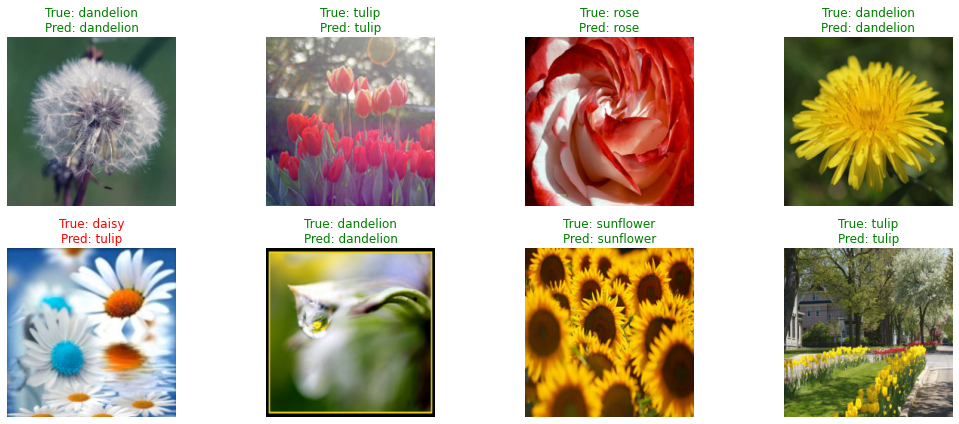

In [46]:
# Visualize predictions from each model

print("Predictions by Custom CNN Model:")
_ = visualize_predictions(custom_model, val_loader, class_names, device)


Predictions by VGG16 Feature Extractor:


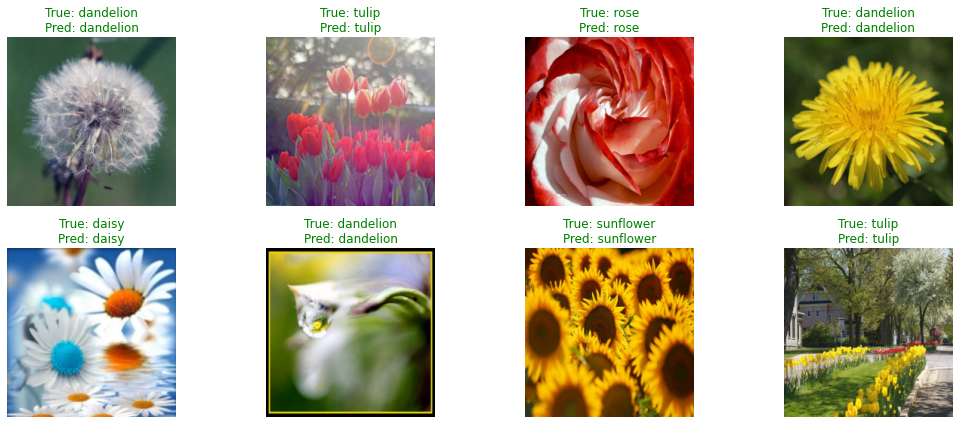

In [47]:
print("\nPredictions by VGG16 Feature Extractor:")
_ = visualize_predictions(vgg_feature_extractor, val_loader, class_names, device)


Predictions by VGG16 Fine-Tuned Model:


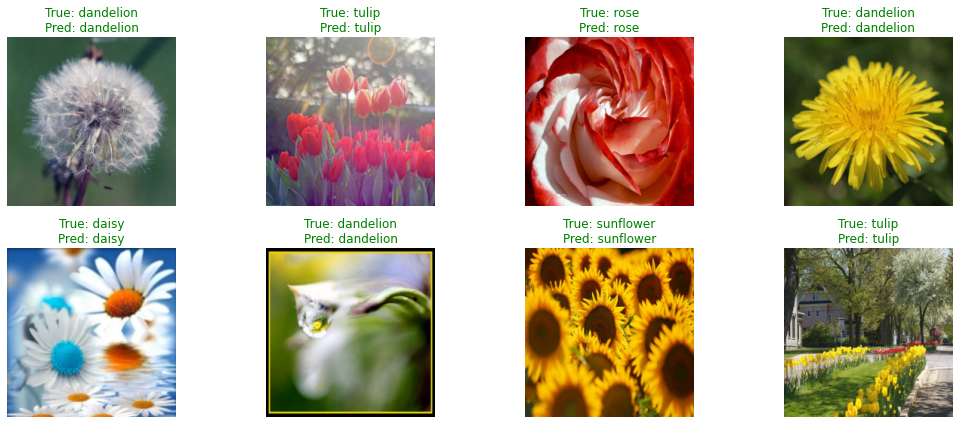

In [48]:
print("\nPredictions by VGG16 Fine-Tuned Model:")
_ = visualize_predictions(vgg_fine_tuned, val_loader, class_names, device)

## 8. Confusion Matrices

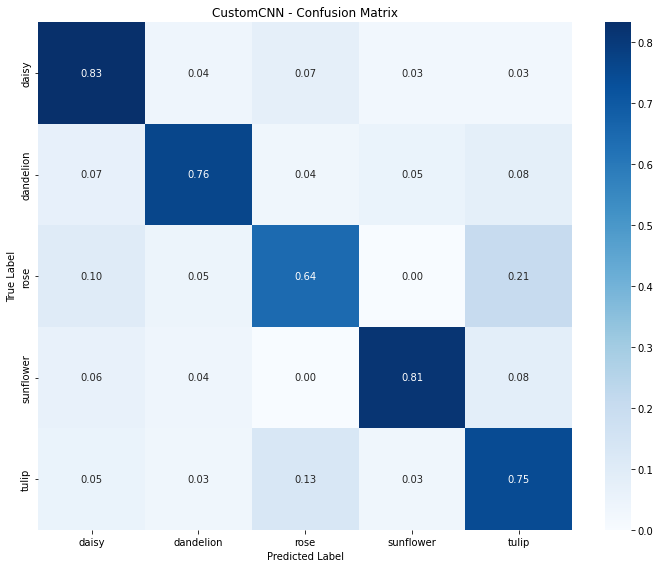

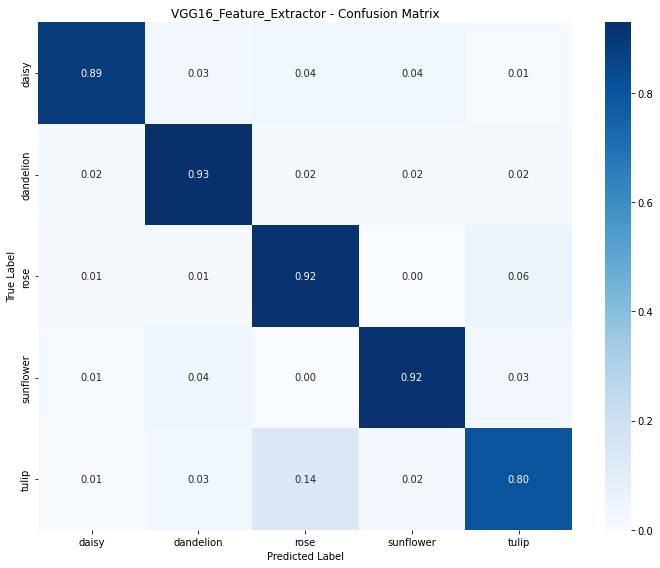

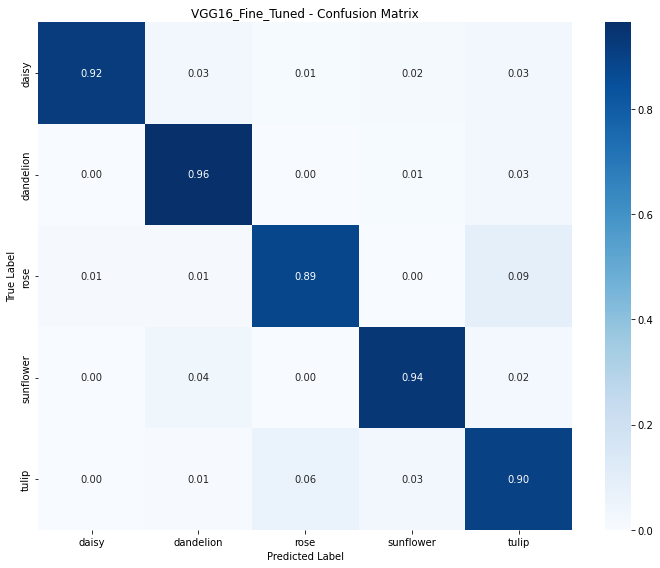

In [39]:
def create_confusion_matrix(model, data_loader, class_names, device, model_name):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return plot_confusion_matrix(all_labels, all_preds, class_names, model_name)

# Create confusion matrices
_ = create_confusion_matrix(custom_model, val_loader, class_names, device, "CustomCNN")
_ = create_confusion_matrix(vgg_feature_extractor, val_loader, class_names, device, "VGG16_Feature_Extractor")
_ = create_confusion_matrix(vgg_fine_tuned, val_loader, class_names, device, "VGG16_Fine_Tuned")

## 9. Performance Comparison

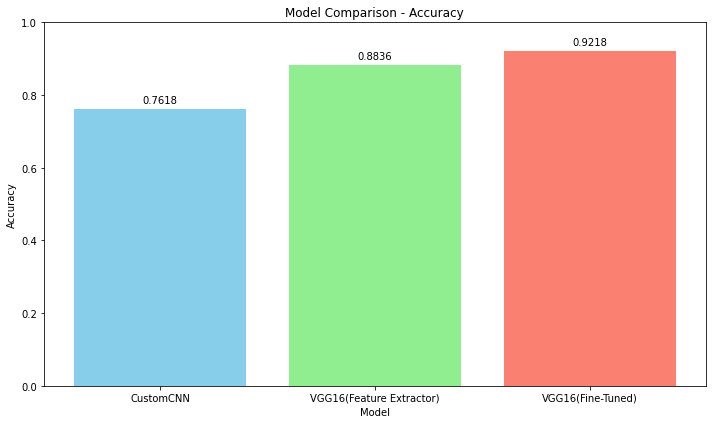

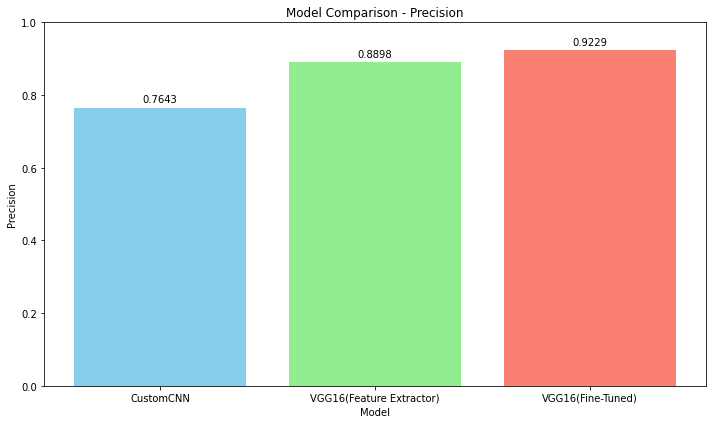

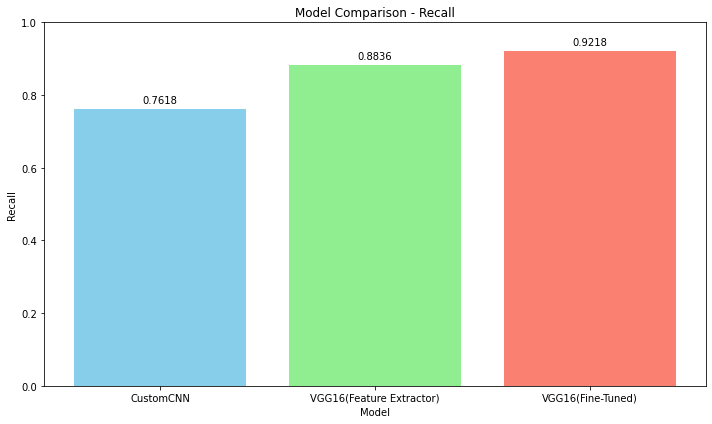

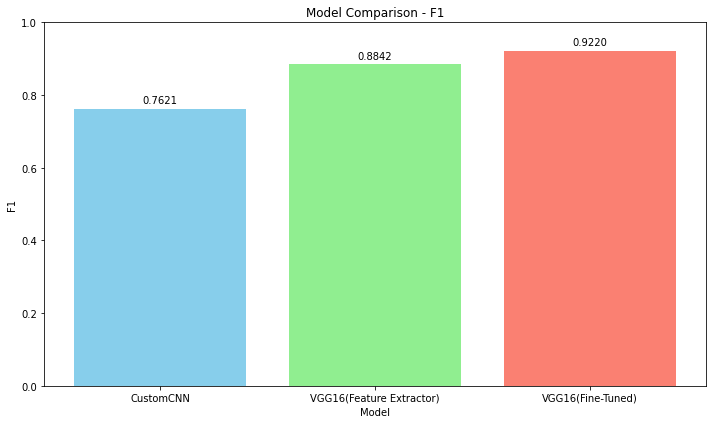

In [40]:
# Plot comparison charts for metrics
_ = plot_comparison_chart(results, 'accuracy')
_ = plot_comparison_chart(results, 'precision')
_ = plot_comparison_chart(results, 'recall')
_ = plot_comparison_chart(results, 'f1')

Train times: [774.5747535228729, 474.04402589797974, 11060.415654182434]


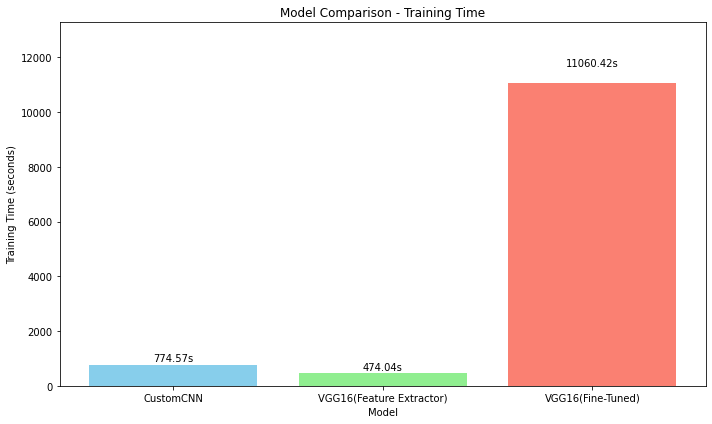

In [43]:
# Compare training times
model_names = list(results.keys())
train_times = [results[model]['train_time'] for model in model_names]

# First check the values
print("Train times:", train_times)

plt.figure(figsize=(10, 6))
# Set a reasonable limit for the y-axis
plt.ylim(0, max(train_times) * 1.2)  # Limit to 20% above the maximum value

bars = plt.bar(model_names, train_times, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Model Comparison - Training Time')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')

# Display values on top of the bars
for bar, value in zip(bars, train_times):
    # Place values slightly above the bars
    plt.text(bar.get_x() + bar.get_width()/2, value * 1.05, 
            f'{value:.2f}s', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../plots/model_comparison_train_time.png')
plt.show()

## 10. Save Results to CSV

In [44]:
# Save results to CSV
with open('../results.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Model", "Accuracy", "Precision", "Recall", "F1", "TrainTime (s)"])
    for model_name, metrics in results.items():
        writer.writerow([model_name, 
                        f"{metrics['accuracy']:.4f}", 
                        f"{metrics['precision']:.4f}", 
                        f"{metrics['recall']:.4f}", 
                        f"{metrics['f1']:.4f}", 
                        f"{metrics['train_time']:.2f}"])

print("Results saved to 'results.csv'.")

Results saved to 'results.csv'.
